In [1]:
import os
import dmd
os.environ["OMP_NUM_THREADS"]='8'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.interpolate import griddata
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [2]:
# N=10000
# K=2
# seed=1
# c=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[0,1,-1]
# omega=np.zeros(N)

# filebase='data/dmd1'
# # loadstr=''
# loadstr='module load cuda &&'
# os.system('mkdir -p %s'%(filebase))

# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=2
# c=1.75
# filebase='data/dmd2'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=N
# c=1.75
# filebase='data/dmd3'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [3]:
# os.system('sbatch jobdmd3.sh')

### Input trajectories

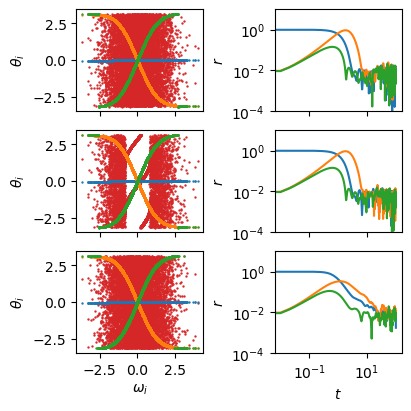

In [2]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
fig,axs=plt.subplots(3,2,figsize=(4,4) ,constrained_layout=True)

numtraj=3

for m in range(len(filebases)):
    for n in range(numtraj):
        filebase='%s/%i'%(filebases[m],n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()

    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(3,2,2+2*m)
        plt.plot(np.arange(len(orders))*dt,orders,c=colors[n],zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$t$')

        
        plt.subplot(3,2,1+2*m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.ylabel(r'$\theta_i$')
        
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$\omega_i$')
    plt.subplot(3,2,1+2*m)
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-6)        
    

# plt.savefig('oscillatordmd1.pdf',dpi=200)
plt.show()

### Mode amplitudes decay exponentially, and order parameter DMD reconstruction is good 

In [5]:
# filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
# resmin=1E-5
# resmax=1E-10
# rescrit=1E-7
# for D in ['0','1','2','3','4','5']:
#     for filebase0 in filebases:
#         phis=np.load('%s%sphis.npy'%(filebase0,D))
#         phitildes=np.load('%s%sphitildes.npy'%(filebase0,D))
#         bs=np.load('%s%sbs.npy'%(filebase0,D))
#         evals=np.load('%s%sevals.npy'%(filebase0,D))
#         res=np.load('%s%sres.npy'%(filebase0,D))
#         n0s=np.concatenate([[0],np.cumsum(np.load('%s%sn0s.npy'%(filebase0,D))-1)])
#         Ndict=phis.shape[0]
#         inds=np.where(res<rescrit)[0]
#         X_reconstruct=np.zeros((bs.shape[0],2*N))
#         for n in range(numtraj):
#             print(filebase0,D,n,end='\r')
#             cos_reconstruct=np.real((bs[n0s[n],inds]*phitildes[inds,:N].T).dot(evals[inds,np.newaxis]**np.arange(n0s[n+1]-n0s[n])[np.newaxis,:])).T
#             sin_reconstruct=np.real((bs[n0s[n],inds]*phitildes[inds,Ndict//2:Ndict//2+N].T).dot(evals[inds,np.newaxis]**np.arange(n0s[n+1]-n0s[n])[np.newaxis,:])).T
#             order=np.abs(np.mean(cos_reconstruct+1j*sin_reconstruct,axis=1))
#             np.save('%s%iorder_%s.npy'%(filebase0,n,D),order)

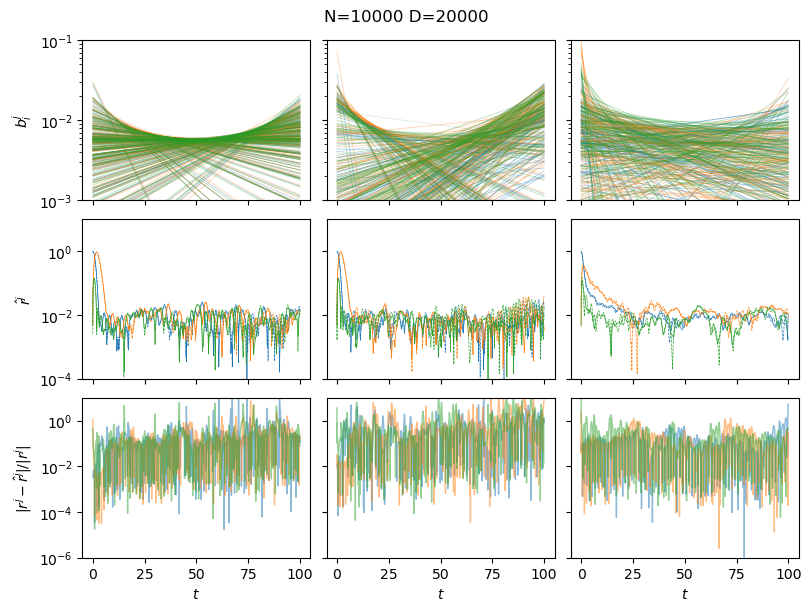

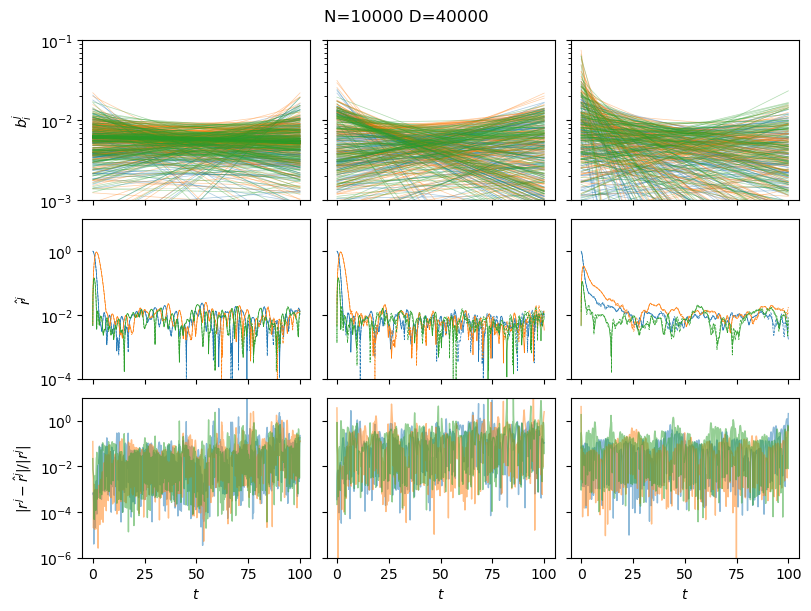

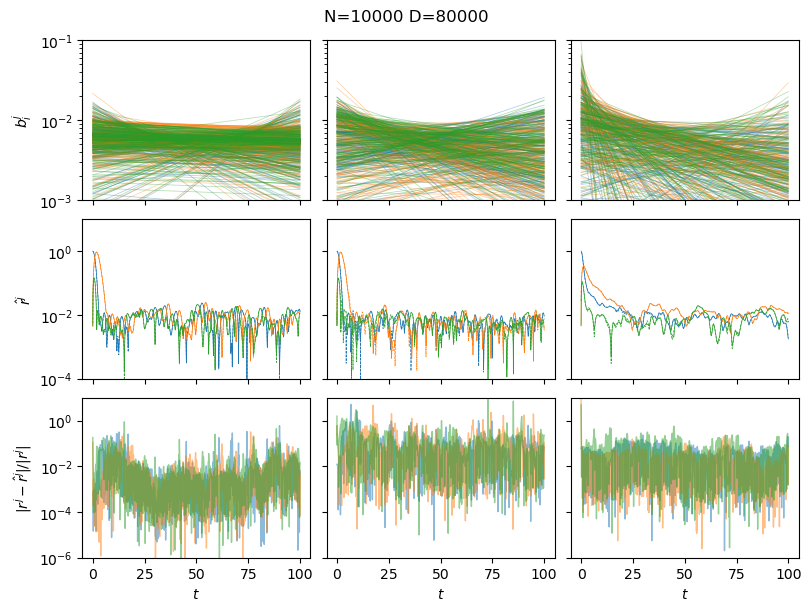

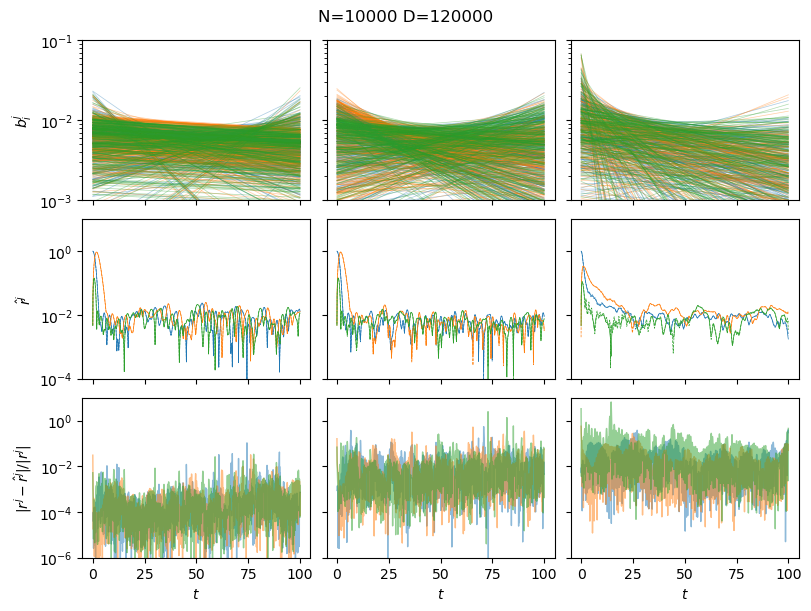

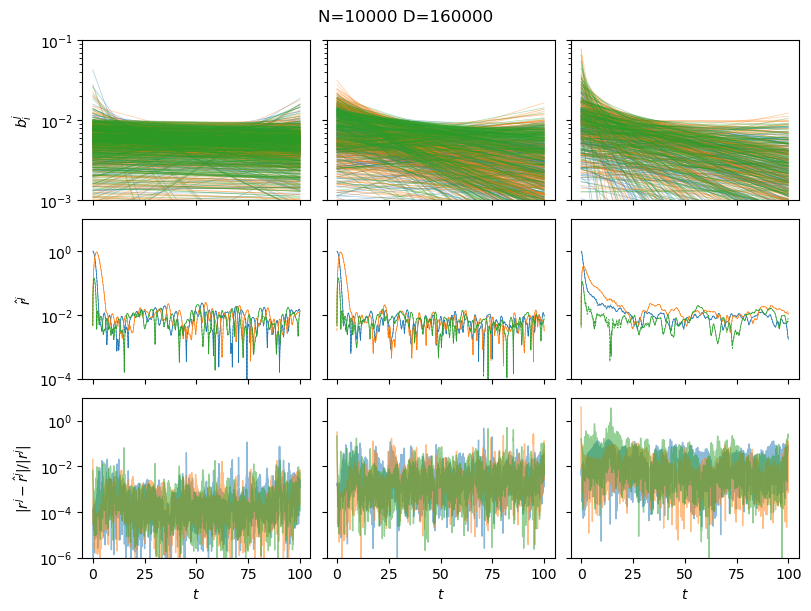

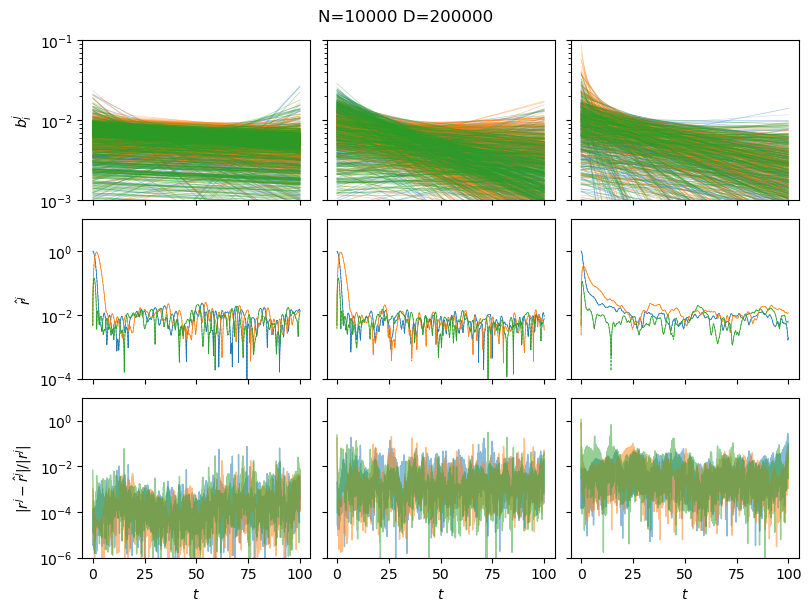

In [6]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
resmin=1E-5
resmax=1E-10
rescrit=1E-7
for D in ['0','1','2','3','4','5']:
    fig,axs=plt.subplots(3,3,figsize=(8,6),layout='constrained')
    M=int(D[0])
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))

    for m in range(len(filebases)):
        filebase0=filebases[m]
        bs=np.load('%s/%sbs.npy'%(filebase0,D))
        evals=np.load('%s/%sevals.npy'%(filebase0,D))
        res=np.load('%s/%sres.npy'%(filebase0,D))
        n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])
        inds=np.where(res<rescrit)[0]
        for n in range(numtraj):
            plt.subplot(3,3,m+1)
            inds2=np.argsort(np.abs(bs[n0s[n],inds]))
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,np.abs(bs[n0s[n]:n0s[n+1],inds[inds2[:]]]),c=colors[n],lw=0.5,alpha=0.2)
            plt.ylim(1E-3,1E-1)
            plt.yscale('log')
            # plt.xscale('log')
            plt.ylim(1E-3,1E-1)
#             plt.xlim(0,50)
            plt.gca().set_xticklabels('')
    
            if m==0:
                plt.ylabel('$b_i^j$')
            else:
                plt.gca().set_yticklabels('')
            plt.gca().set_xticklabels('')
                    
            plt.subplot(3,3,m+4)
            filebase='%s/%i'%(filebases[m],n)
            orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
            rorders=np.load(filebase+'order_%s.npy'%(D))
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,rorders,c=colors[n],ls='--',zorder=-5,lw=0.5)
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,orders[:-1],c=colors[n],zorder=-5,lw=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.ylim(1E-4,1E1)
#             plt.xlim(0,50)
            if m==0:
                plt.ylabel('$\hat{r}^j$')
            else:
                plt.gca().set_yticklabels('')
            plt.gca().set_xticklabels('')
                
            plt.subplot(3,3,m+7)
            err=np.abs(rorders-orders[:-1])/orders[:-1]
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,err,c=colors[n],zorder=-5,lw=1,alpha=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('$t$')
            plt.ylim(1E-6,1E1)
#             plt.xlim(0,50)
            if m==0:
                plt.ylabel(r'${ | r^j-\hat{r}^j  |}/{ | r^j  |}$')
            else:
                plt.gca().set_yticklabels('')
            


                
    plt.savefig('oscillatordmd3_%s.pdf'%D)
    plt.show()

In [5]:
ds=[]
es=[]
for D in ['0','1','2','3','4','5']:
    M=int(D[0])
    if M==0:
        d=N*2
    else:
        d=N*2*M+N/2*4*M
        
    for m in range(len(filebases)):
        filebase0=filebases[m]
        for n in range(numtraj):
            ds=ds+[d]
            filebase='%s/%i'%(filebases[m],n)
            orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
            rorders=np.load(filebase+'order_%s.npy'%(D))
#             es=es+[np.mean(((orders[:-1]-rorders)/orders[:-1])**2)**0.5]
            es=es+[np.mean(((orders[:-1]-rorders))**2)**0.5]

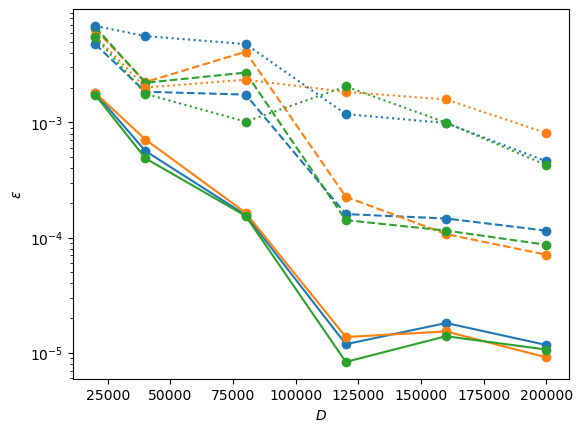

In [6]:
plt.plot(ds[::9],es[::9],marker='o',c=colors[0],ls='-')
plt.plot(ds[1::9],es[1::9],marker='o',c=colors[1],ls='-')
plt.plot(ds[2::9],es[2::9],marker='o',c=colors[2],ls='-')
plt.plot(ds[3::9],es[3::9],marker='o',c=colors[0],ls='--')
plt.plot(ds[4::9],es[4::9],marker='o',c=colors[1],ls='--')
plt.plot(ds[5::9],es[5::9],marker='o',c=colors[2],ls='--')
plt.plot(ds[6::9],es[6::9],marker='o',c=colors[0],ls=':')
plt.plot(ds[7::9],es[7::9],marker='o',c=colors[1],ls=':')
plt.plot(ds[8::9],es[8::9],marker='o',c=colors[2],ls=':')
plt.xlabel(r'$D$')
plt.ylabel(r'$\varepsilon$')
plt.yscale('log')
plt.savefig('errors.pdf')

### DMD spectrum and pseudospectrum

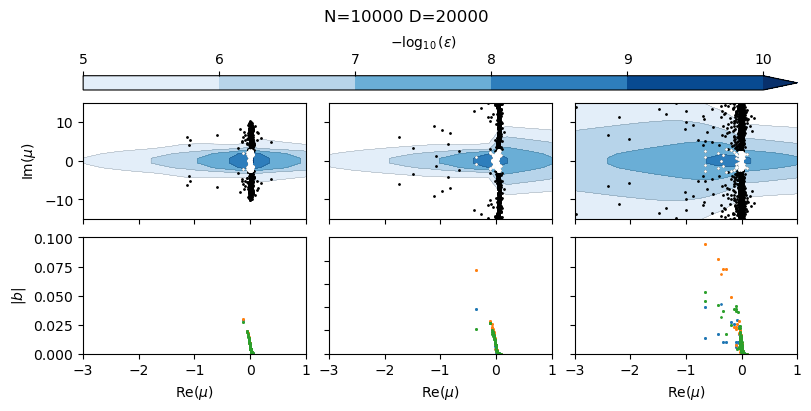

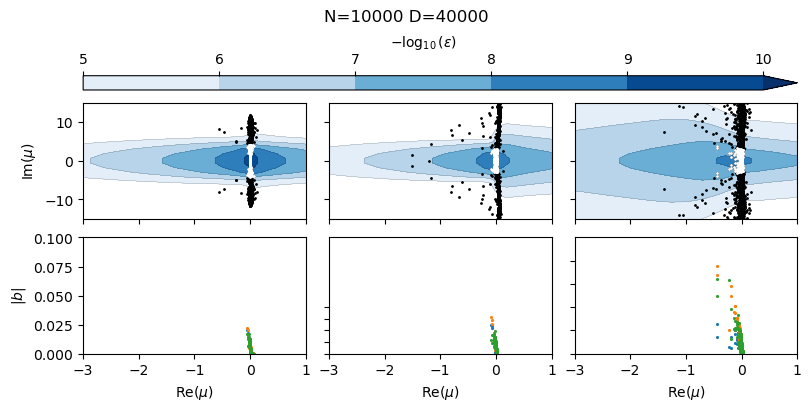

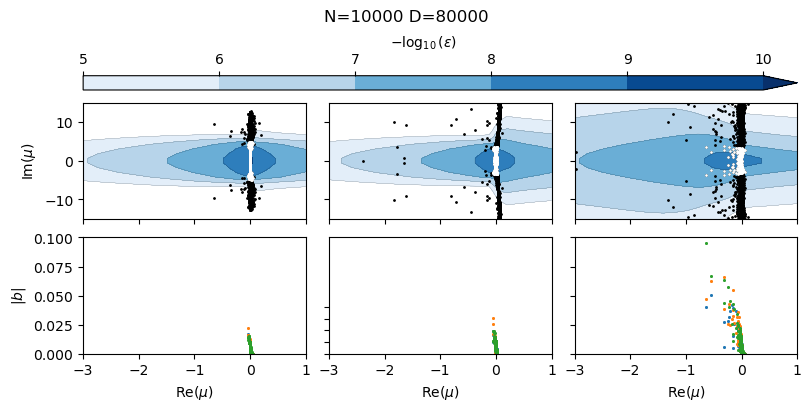

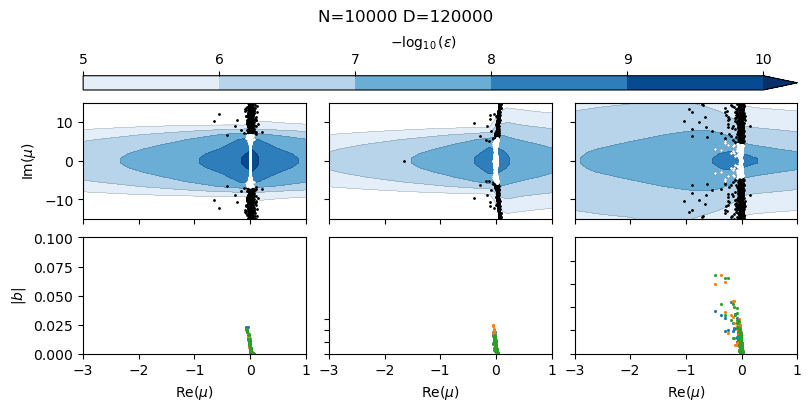

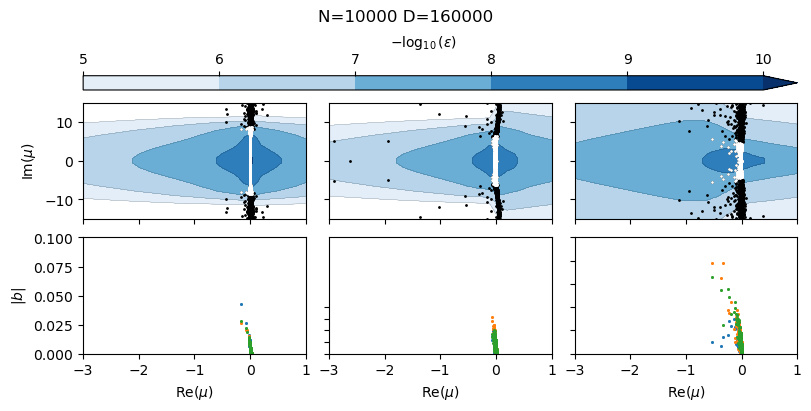

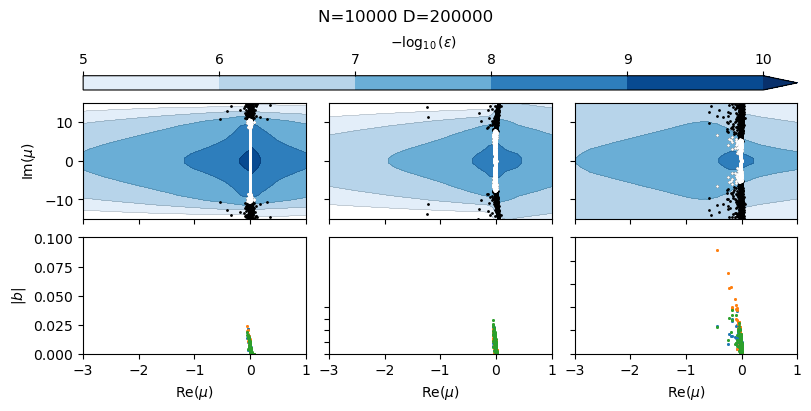

In [9]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
resmin=1E-5
resmax=1E-10
rescrit=1E-7

for D in ['0','1','2','3','4','5']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    M=int(D[0])
    
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))
    numtraj=3
    for m in range(len(filebases)):
        filebase0=filebases[m]
        
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals)/dt)
        n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])
        
        plt.subplot(2,3,4+l)
    
        # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
        for n in range(numtraj):
            plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
    
        plt.xlabel(r'$\mathrm{Re}(\mu)$')
        plt.xlim(-3,1)
        if l>0:
            plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
        else:
            plt.ylabel(r'$|b|$')
        plt.ylim(0,0.1)
    
        pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
        zs1=np.load('%s/%szs.npy'%(filebase0,D))
        evals1=np.load('%s/%sevals.npy'%(filebase0,D))
        res1=np.load('%s/%sres.npy'%(filebase0,D))
        nr=26
        ni=26
        
        levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
        plt.subplot(2,3,1+l)
        cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,cmap='Blues',extend='max',zorder=-5)
        cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)
    
        plt.gca().set_rasterization_zorder(0)
        plt.xlim(-3,1)
        plt.ylim(-15,15)
        
        xs1=np.real(np.log(evals1)/dt)
        ys1=np.imag(np.log(evals1)/dt)
    
        inds=np.where(res1<rescrit)[0]
        plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
        plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)
        
        if l>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel('$\mathrm{Im}({\mu})$')
        plt.gca().set_xticklabels('')
    
        l=l+1
    
    fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
#     plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

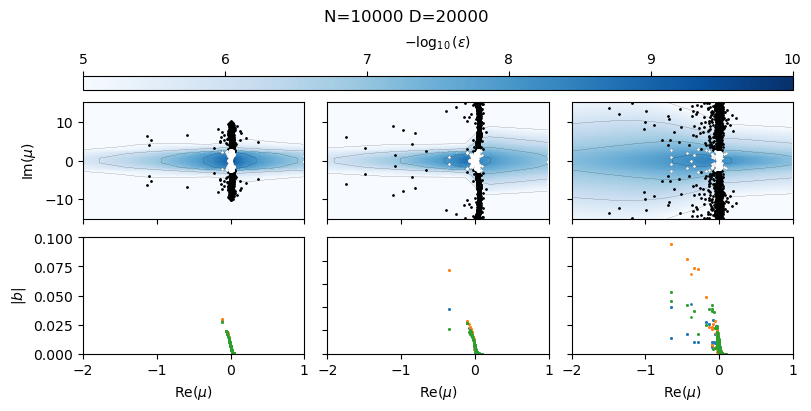

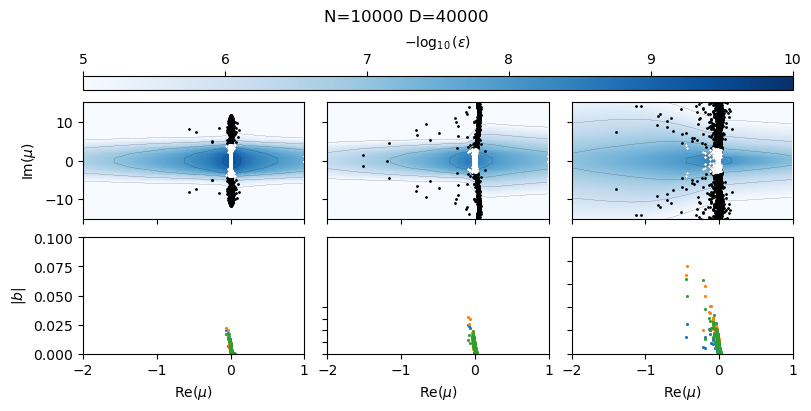

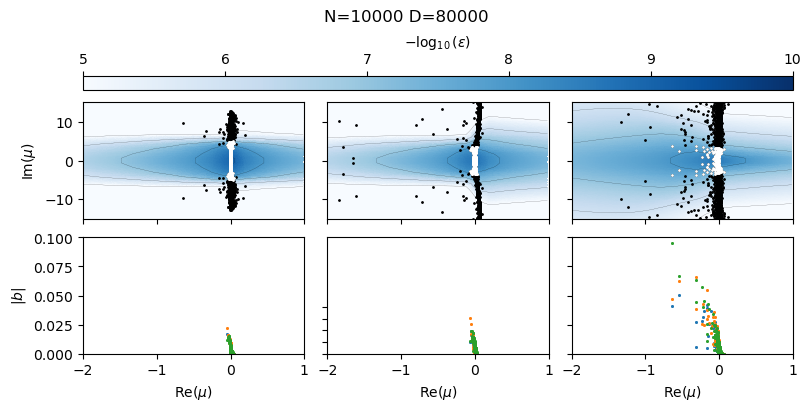

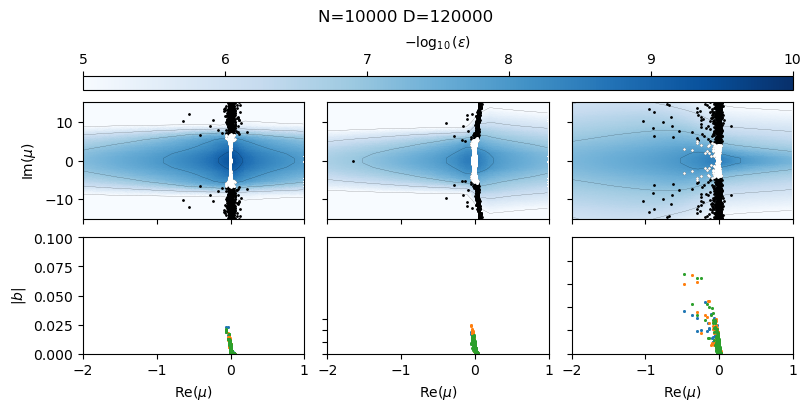

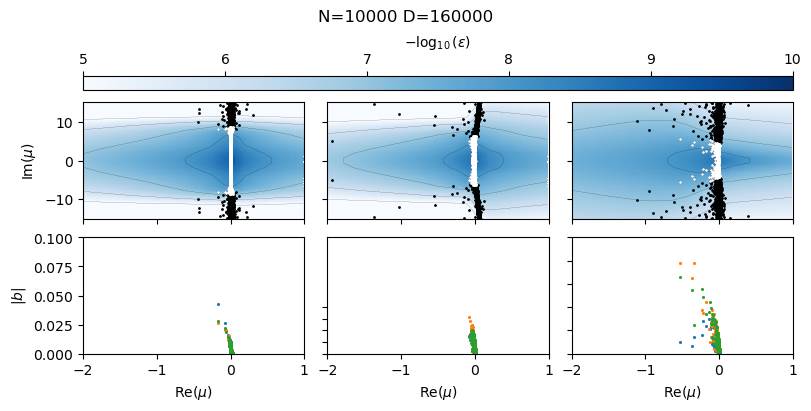

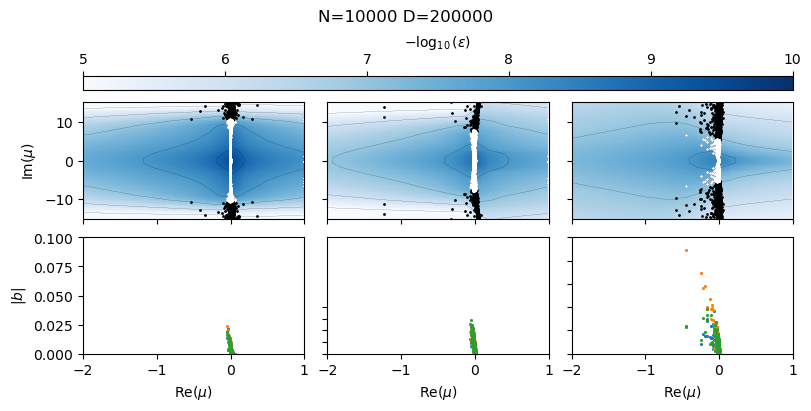

In [4]:
filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
omega=np.fromfile(filebases[0]+'0'+'frequencies.dat',dtype=np.float64)
N=len(omega)

resmin=1E-5
resmax=1E-10
rescrit=1E-7

for D in ['0','1','2','3','4','5']:
    l=0
    M=int(D[0])
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    if M==0:
        fig.suptitle('N=%i D=%i'%(N,N*2))
    else:
        fig.suptitle('N=%i D=%i'%(N,N*2*M+N/2*4*M))
    numtraj=3
    for m in range(len(filebases)):
        try:
            filebase0=filebases[m]

            bs=np.load(filebase0+str(D)+'bs.npy')
            evals=np.load(filebase0+str(D)+'evals.npy')
            res=np.load(filebase0+str(D)+'res.npy')
            inds=np.where(res<rescrit)[0]
            xs=np.real(np.log(evals)/dt)
            n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])

            plt.subplot(2,3,4+l)

            # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
            for n in range(numtraj):
                plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
            plt.gca().set_rasterization_zorder(0)

            plt.xlabel(r'$\mathrm{Re}(\mu)$')
            plt.xlim(-2,1)
            if l>0:
                plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
            else:
                plt.ylabel(r'$|b|$')
            plt.ylim(0,0.1)

            pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
            zs1=np.load('%s/%szs.npy'%(filebase0,D))
            evals1=np.load('%s/%sevals.npy'%(filebase0,D))
            res1=np.load('%s/%sres.npy'%(filebase0,D))
            nr=26
            ni=26

            levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5

            plt.subplot(2,3,1+l)
#             X=np.concatenate([np.real(np.log(zs1)/dt),np.real(np.log(evals1)/dt)])
#             Y=np.concatenate([np.imag(np.log(zs1)/dt),np.imag(np.log(evals1)/dt)])
#             C=np.concatenate([np.log(1/np.array(pseudo1))/np.log(10),np.log(1/np.array(res1))/np.log(10)])
            X=np.real(np.log(zs1)/dt)
            Y=np.imag(np.log(zs1)/dt)
            C=np.log(1/np.array(pseudo1))/np.log(10)

            x=-3+4*np.arange(256)/256
            y=-15+30*np.arange(256)/256
            X2,Y2=np.meshgrid(x,y)
            xi=np.array([X2,Y2]).transpose(1,2,0).reshape(-1,2)
            C2=griddata(np.array([X,Y]).T,C,xi)
            Cinds=np.where(np.isfinite(C2))[0]
            C2=C2[Cinds]
            X2=X2.ravel()[Cinds]
            Y2=Y2.ravel()[Cinds]

            cs2=plt.gca().tripcolor(X2.ravel(),Y2.ravel(),C2,cmap='Blues',zorder=-6,vmin=-np.log(resmin)/np.log(10),vmax=-np.log(resmax)/np.log(10))
            inds=np.where(np.isfinite(C2))[0]
            cs1 = plt.gca().tricontour(X2.ravel()[inds],Y2.ravel()[inds],C2[inds],levels=levels,colors='k',linewidths=0.1,extend='max',zorder=-5)

            plt.gca().set_rasterization_zorder(0)
            plt.xlim(-2,1)
            plt.ylim(-15,15)

            xs1=np.real(np.log(evals1)/dt)
            ys1=np.imag(np.log(evals1)/dt)

            inds=np.where(res1<rescrit)[0]
            plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
            plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)

            if l>0:
                plt.gca().set_yticklabels([])
            else:
                plt.ylabel('$\mathrm{Im}({\mu})$')
            plt.gca().set_xticklabels('')
        except:
            continue
        l=l+1
    
    fig.colorbar(cs2, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
    plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

In [11]:
rescrit

1e-07

In [17]:
rescrit=1E-7
for filebase0 in filebases:
    for D in ['1','2','3','4','5']:
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals[inds])/dt)
        print(np.min(xs))

-0.059694216005093434
-0.04508650156260949
-0.06876215955853968
-0.16513736466322973
-0.05384463620740986
-0.08666688911939613
-0.05907448774778145
-0.05169616945056428
-0.0728330938739926
-0.0593758331368259
-0.4428658627241161
-0.6433335018900075
-0.47877148042433476
-0.5237716033268343
-0.4477553325023946


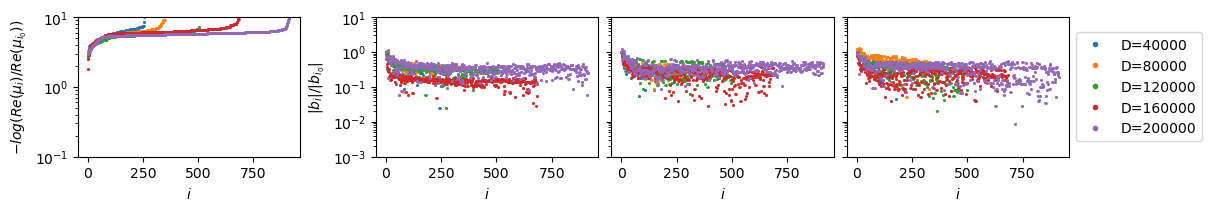

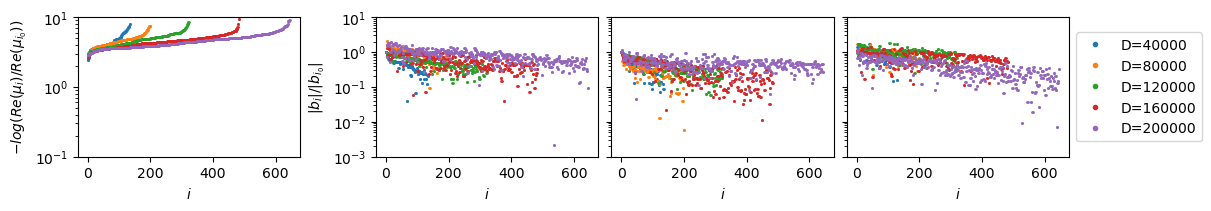

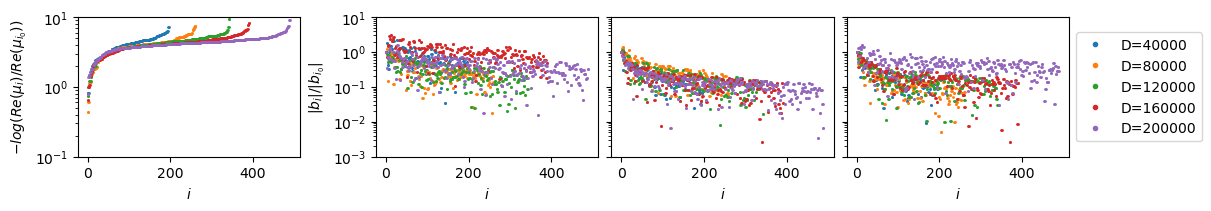

In [3]:
for filebase0 in filebases:
    resmin=1E-5
    resmax=1E-10
    rescrit=1E-7
    plt.subplots(1,4,figsize=(12,2),layout='constrained')

    for D in ['1','2','3','4','5']:
        M=int(D[0])
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals[inds])/dt)
        n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])

        plt.subplot(1,4,1)
        sinds=np.intersect1d(np.where(-np.sort(xs)<3)[0],np.where(np.sort(xs)<0)[0])
        vals=xs[np.argsort(xs)][sinds]
        plt.plot(-np.log(np.abs(vals)),marker='o',lw=0,ms=1)
        plt.yscale('log')
        plt.ylabel('$-log(Re(\mu_i)/Re(\mu_{i_0}))$')
        plt.xlabel('$i$')
        plt.ylim(1E-1,1E1)


        plt.subplot(1,4,2)
        vals=np.abs(bs[n0s[0]])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.ylabel('$|b_i|/|b_{i_0}|$')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)

        plt.subplot(1,4,3)
        vals=np.abs(bs[n0s[1]])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)
        plt.gca().set_yticklabels('')

        plt.subplot(1,4,4)
        vals=np.abs(bs[n0s[2]])[inds][np.argsort(xs)][sinds]
        plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
        plt.yscale('log')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E1)
        plt.gca().set_yticklabels('')
    plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
    plt.show()

omegamin -0.08666688911939613
omegamin -0.04508650156260949
omegamin -0.06876215955853968
omegamin -0.060536890753425866
omegamin -0.05384463620740986


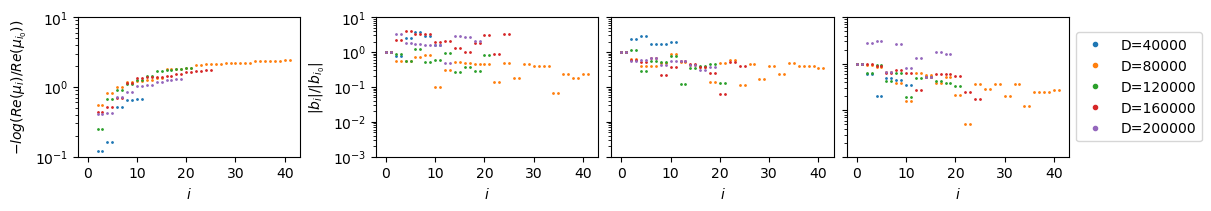

In [22]:
resmin=1E-5
resmax=1E-10
rescrit=5E-8
plt.subplots(1,4,figsize=(12,2),layout='constrained')

for D in ['1','2','3','4','5']:
    omegamin=0
    for filebase0 in filebases[:-1]:
        M=int(D[0])
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals[inds])/dt)
        omegamin=np.min([omegamin,np.min(xs)])
    print('omegamin',omegamin)

    filebase0=filebases[-1]
    M=int(D[0])
    bs=np.load(filebase0+str(D)+'bs.npy')
    evals=np.load(filebase0+str(D)+'evals.npy')
    res=np.load(filebase0+str(D)+'res.npy')
    inds=np.where(res<rescrit)[0]
    xs=np.real(np.log(evals[inds])/dt)
    n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])

    plt.subplot(1,4,1)
    sinds=np.intersect1d(np.where(-np.sort(xs)<3)[0],np.where(np.sort(xs)<omegamin)[0])
    vals=xs[np.argsort(xs)][sinds]
    plt.plot(-np.log(vals/vals[0]),marker='o',lw=0,ms=1)
    plt.yscale('log')
    plt.ylabel('$-log(Re(\mu_i)/Re(\mu_{i_0}))$')
    plt.xlabel('$i$')
    plt.ylim(1E-1,1E1)


    plt.subplot(1,4,2)
    vals=np.abs(bs[n0s[0]])[inds][np.argsort(xs)][sinds]
    plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
    plt.yscale('log')
    plt.ylabel('$|b_i|/|b_{i_0}|$')
    plt.xlabel('$i$')
    plt.ylim(1E-3,1E1)

    plt.subplot(1,4,3)
    vals=np.abs(bs[n0s[1]])[inds][np.argsort(xs)][sinds]
    plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
    plt.yscale('log')
    plt.xlabel('$i$')
    plt.ylim(1E-3,1E1)
    plt.gca().set_yticklabels('')

    plt.subplot(1,4,4)
    vals=np.abs(bs[n0s[2]])[inds][np.argsort(xs)][sinds]
    plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='D=%i'%(N*2*M+N/2*4*M))
    plt.yscale('log')
    plt.xlabel('$i$')
    plt.ylim(1E-2,1E1)
    plt.gca().set_yticklabels('')
plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
plt.show()